In [0]:
from keras.preprocessing.image import load_img,img_to_array,save_img
from keras import backend as K


target_image_path = '../../content/ta.jpg'
style_reference_image_path = '../../content/popova.jpg'

width,height = load_img(target_image_path).size
img_height = 400
img_width = int(width*img_height/height)

In [0]:

import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
  img = load_img(image_path, target_size = (img_height,img_width))
  img = img_to_array(img)
  img = np.expand_dims(img,axis=0)
  img = vgg19.preprocess_input(img)
  return img

def deprocess_image(x):
  x[:,:,0]+=103.939
  x[:,:,1]+=116.779
  x[:,:,2]+=123.68
  x=x[:,:,::-1] # BGR TO RGB
  x=np.clip(x,0,255).astype('uint8')
  return x


In [0]:

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1,img_height,img_width,3))

input_tensor = K.concatenate([target_image,style_reference_image,combination_image],axis=0) # 3 in 1 batch
model=vgg19.VGG19(input_tensor=input_tensor,weights='imagenet',include_top =False)
print('Model Load Fin')

Model Load Fin


In [0]:
def content_loss(base,combination):
  return K.sum(K.square(combination-base))

def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
  gram = K.dot(features,K.transpose(features)) # K @  Kt
  return gram

def style_loss(style,combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height*img_width
  return K.sum(K.square(S-C))/(4.*(channels**2)*(size**2))

def total_variation_loss(x):
  a = K.square(x[:,:img_height-1,:img_width-1,:] - x[:,1:,:img_width-1,:])
  b = K.square(x[:,:img_height-1,:img_width-1,:] - x[:,:img_height-1,1:,:])
  return K.sum(K.pow(a+b,1.25))

In [0]:
outputs_dict = dict([(layer.name,layer.output) for layer in model.layers]) # layer name : output
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
total_variation_weight = 1e-4
style_weight =1.
content_weight = 0.0015

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]
loss += content_weight*content_loss(target_image_features,combination_features)

for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_reference_features = layer_features[1,:,:,:]
  combination_features = layer_features[2,:,:,:]
  sl =style_loss(style_reference_features,combination_features)
  loss += (style_weight/len(style_layers))*sl

loss +=total_variation_weight*total_variation_loss(combination_image)

In [0]:
grads = K.gradients(loss,combination_image)[0]

fetch_loss_and_grads = K.function([combination_image],[loss,grads])

class Evaluator(object):

  def __init__(self):
    self.loss_value = None
    self.grads_values = None

  def loss(self,x):
    assert self.loss_value is None
    x = x.reshape((1,img_height,img_width,3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value

  def grads(self,x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values
  
evaluator = Evaluator()

In [0]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()

for i in range(iterations):
  print('iterations:',i)
  start_time = time.time()
  x,min_val,info = fmin_l_bfgs_b(evaluator.loss,x,fprime = evaluator.grads,maxfun = 20)
  print('loss val:',min_val)
  img = x.copy().reshape((img_height,img_width,3))
  img = deprocess_image(img)
  fname = result_prefix+'_at_iteration_%d.png'%i
  save_img(fname,img)
  print('Saved Image:',fname)
  end_time = time.time()
  print('%d Iteration: %ds'%(i,end_time-start_time))

iterations: 0
loss val: 2840633900.0
Saved Image: style_transfer_result_at_iteration_0.png
0 Iteration: 2s
iterations: 1
loss val: 1219080400.0
Saved Image: style_transfer_result_at_iteration_1.png
1 Iteration: 1s
iterations: 2
loss val: 722326600.0
Saved Image: style_transfer_result_at_iteration_2.png
2 Iteration: 1s
iterations: 3
loss val: 565235140.0
Saved Image: style_transfer_result_at_iteration_3.png
3 Iteration: 1s
iterations: 4
loss val: 469944930.0
Saved Image: style_transfer_result_at_iteration_4.png
4 Iteration: 1s
iterations: 5
loss val: 402718400.0
Saved Image: style_transfer_result_at_iteration_5.png
5 Iteration: 1s
iterations: 6
loss val: 348852160.0
Saved Image: style_transfer_result_at_iteration_6.png
6 Iteration: 1s
iterations: 7
loss val: 308746180.0
Saved Image: style_transfer_result_at_iteration_7.png
7 Iteration: 1s
iterations: 8
loss val: 284782200.0
Saved Image: style_transfer_result_at_iteration_8.png
8 Iteration: 1s
iterations: 9
loss val: 261766940.0
Saved Im

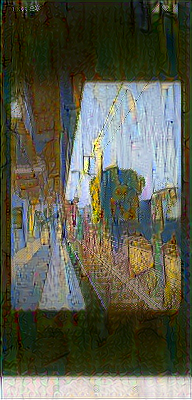

In [0]:
load_img('../../content/style_transfer_result_at_iteration_19.png')

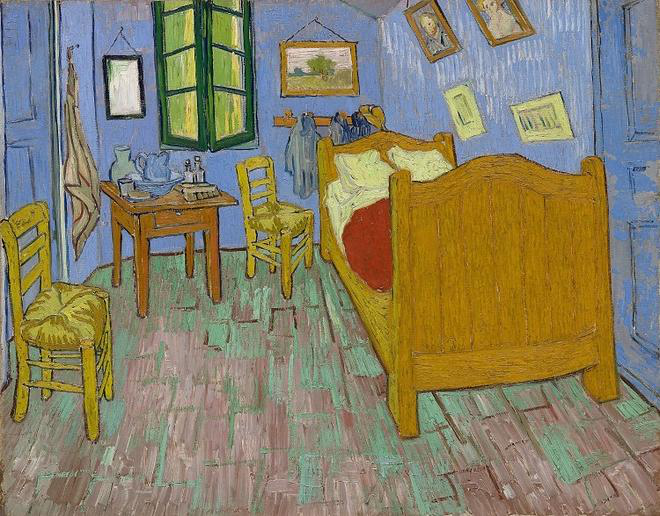

In [0]:
load_img('../../content/popova.jpg')